In [509]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import psycopg2
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [510]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    return df

In [511]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [512]:
for route in routes:
    add_extra_data(route)

In [513]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (92505, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [514]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7
Making API call to get all stops on route  14
Making API call to get all stops on route  14
Making API call to get all stops on route  35
Making API call to get all stops on route  35
Making API call to get all stops on route  37
Making API call to get all stops on route  37
Making API call to get all stops on route  69
Making API call to get all stops on route  69
Making API call to get all stops on route  328
Making API call to get all stop

# Data Analytics

## Helper Functions

In [515]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

In [516]:
import random

def random_date(start, end, prop):
    """
    Generates a random date in between the start and end date given
    """
    
    stime = convert_time_to_datetime(start)
    etime = convert_time_to_datetime(end)

    ptime = stime + prop * (etime - stime)
    return ptime

In [576]:
def detect_outlier_z_score(travel_times):
    outlier_indexes = []
    
    threshold = 3
    mean = np.mean(travel_times)
    std = np.std(travel_times)
    
    for i, t in enumerate(travel_times):
        z_score= (t - mean) / std
        
        if np.abs(z_score) > threshold:
            outlier_indexes.append(i)
    
    return outlier_indexes

## Predict journey time by taking recent information into account 

In [517]:
# Generate random list of request times
def generate_random_request_times(start, end, num_times):
    """
    start: start time
    end: end time
    num_times: the number of times to generate
    """
    
    req_times_random = [random_date(start, end, random.random()) for x in range(num_times)]
    format = '%Y-%m-%d %H:%M:%S'
    req_times_random.sort()
    req_times = [t.strftime(format) for t in req_times_random]
    print(req_times)
    return req_times

In [580]:
def get_times_past_2_hours(stop_a, stop_b, a_id, req_time):
    
    """
    journey_times 
        - is a list of journey times for a bus arriving at stop b within the past 2 hours of the request time.
    most_recent_left
        - is the last vehicle to leave stop a and arrive at stop b before req_time
    arrived_journeys
        - is a list of bus details for vehicles arriving at stop b within the past 2 hours of the request time.
    """

    journey_times = []
    most_recent_left = -1
    arrived_journeys = []
    req_time = convert_time_to_datetime(req_time)

    for i, journey in stop_b.iterrows():
        arr_dt = convert_time_to_datetime(journey['expected_arrival'])
        past_2_hours = req_time - dt.timedelta(hours = 2)

        if (arr_dt >= past_2_hours) & (arr_dt < req_time):
            # arrived within past 2 hours and before request time
            [bus_id, b_id, date, direction, _] = journey['vehicle_id'].split('_')
            to_match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_'
            
            for j, match in stop_a.iterrows():
                if match['vehicle_id'].startswith(to_match_id):
                    leave_dt = convert_time_to_datetime(match['expected_arrival'])
                    journey_time = arr_dt - leave_dt

                    if (journey_time > dt.timedelta(minutes = 0)) & (journey_time < dt.timedelta(minutes = 50)):
                        most_recent_left = j
                        arrived_journeys.append(journey)
                        journey_times.append(journey_time)
    
#     if most_recent_left != -1:
#         recent = stop_a.loc[most_recent_left, 'expected_arrival']
#         print("most recent left bus left at ", recent)
        
    return most_recent_left, arrived_journeys, journey_times

In [581]:
weights = {"10": 0.6, "20": 0.25, "40": 0.1, "80": 0.04, "120": 0.01}

def predict_journey_time(req_time, stop_a, stop_b, a_id):
    """
    - A request for the predicted journey time of a bus arriving at stop b is 
    made at req_time
    - Returns the predicted journey time based on journey times in the past 2 hours.
    - Journey times from the past 2 hours are weighted depending on how long ago
    they were compared to the request time.
    - most_recent_left is the the last bus that left stop a and arrived at stop be before
    req_time.

    """
    
    most_recent_left_indx, arrived, journey_times = get_times_past_2_hours(stop_a, stop_b, a_id, req_time)
    
    pred = 0
    sum_weights = 0
    for index, item in enumerate(arrived):
        eta = convert_time_to_datetime(item["expected_arrival"])
        diff = convert_time_to_datetime(req_time) - eta
        weight = 0
        if (diff <= dt.timedelta(minutes = 120)) & (diff > dt.timedelta(minutes = 80)):
            weight = weights["120"]
        elif (diff <= dt.timedelta(minutes = 80)) & (diff > dt.timedelta(minutes = 40)):
            weight = weights["80"]
        elif (diff <= dt.timedelta(minutes = 40)) & (diff > dt.timedelta(minutes = 20)):
            weight = weights["40"]
        elif (diff <= dt.timedelta(minutes = 20)) & (diff > dt.timedelta(minutes = 10)):
            weight = weights["20"]
        elif (diff <= dt.timedelta(minutes = 10)) & (diff > dt.timedelta(minutes = 0)):
            weight = weights["10"]
        journey_time = journey_times[index].total_seconds()
        pred += weight * journey_time
        sum_weights += weight
    
    if (sum_weights == 0) or (most_recent_left_indx == -1):
        return pred, most_recent_left_indx
    
    pred = pred / sum_weights
    
    return pred, most_recent_left_indx

In [582]:
def pred_arrival_time(req_time, leave_stop, pred, most_recent_left):
    """
    Finds the nearest vehicle (i.e. the one that will arrive the earliest to stop b) and 
    adds the predicted journey time onto its leave time.
    
    Params
    - req_time: the time of request
    - leave_stop: stop that is being used to find the bus to track i.e. stop_a
    - pred: predicted journey time (found previously)
    - most_recent_left: the index of the bus that left leave_stop the last but
    arrived at stop_a before the request time.
    
    Returns
    - the predicted arrival time of the bus at stop B
    - the actual vehicle that is being tracked.
    """
    req_time = convert_time_to_datetime(req_time)

    for i, bus in leave_stop.iterrows():
        if i > most_recent_left:
            # Ensures that it will arrive at stop b either ON or AFTER req_time
            leave_time = convert_time_to_datetime(bus['expected_arrival'])
            # This vehicle is the one that left immediately after

#             print("leave time = ", leave_time)
            # else: The nearest vehicle left stop a after the request time, so this wouldn't count as historical data")
            if leave_time <= req_time:
                # 30 second leeway for loading and unloading passengers
                pred_arrival = leave_time + dt.timedelta(seconds = (pred + 30))
                return pred_arrival, bus
            break
                
    # Theoretically shouldn't get to this unless most_recent_left is the last item in the list already
    print("There are no more buses due")    
    return 0, []

In [583]:
def get_actual(arr_stop, req_time, bus_to_track, arr_stop_id):
    """
    Params:
    - arr_stop: arrival stop = stop_b
    - req_time: time of request
    - bus_to_track: the bus that is being tracked to find its actual arrival time
    - arr_stop_id: stop b id
    
    Returns the first bus that arrives at arr_stop immediately after req_time.
    Returns None if there is no bus that arrives after req_time.
    """
    [bus_id, a_id, date, direction, _] = bus_to_track['vehicle_id'].split('_')
    to_match_id = bus_id + '_' + arr_stop_id + '_' + date + '_' + direction + '_'
    leave_time = convert_time_to_datetime(bus_to_track['expected_arrival'])
    
    req_time = convert_time_to_datetime(req_time)
    for i, bus in arr_stop.iterrows():
        actual_arr_time = convert_time_to_datetime(bus['expected_arrival'])
        
        if bus['vehicle_id'].startswith(to_match_id):
            
            if actual_arr_time > req_time:
                actual_jrny_time = actual_arr_time - leave_time + dt.timedelta(seconds = 30)
                print("Actual journey time is {}".format(actual_jrny_time))
                print("Actual arrival time is {}".format(actual_arr_time))
                return actual_arr_time, actual_jrny_time
        
    return -1, -1

In [584]:
def pred_eval_arrival_times_mult(req_time, stop_a, stop_b, a_id, b_id):
    """
    Use for testing and training
    
    If I request the arrival time of a bus at stop B at req_time, what is the predicted
    arrival time of the nearest bus?
    
    Returns the predicted and actual arrival time of a bus at stop B.
    If the actual bus data cannot be found, the actual arrival time = 0.
    
    """
    
    print("Request time is ", req_time)
    
    pred_jrny_time, most_recent_left = predict_journey_time(req_time, stop_a, stop_b, a_id)
    print("Predicted journey time is ", (pred_jrny_time / 60))
    if pred_jrny_time == 0:
        print("Couldn't find any journeys")
        return 0, 0, 0, 0
    
    pred_arr, bus_to_track = pred_arrival_time(req_time, stop_a, pred_jrny_time, most_recent_left)
    
    if isinstance(bus_to_track, list):
        print("Cannot find correlating leaving bus.")
        return pred_arr, 0, 0, 0
    
    print("Predicted arrival time is {}".format(pred_arr))
    actual_arr, actual_jrny_time = get_actual(stop_b, req_time, bus_to_track, b_id)
    
    if actual_arr == -1:
        print("There is no bus arriving at req_time")
        return pred_arr, 0, 0, 0
    
    return pred_arr, actual_arr, pred_jrny_time, actual_jrny_time

### All Souls Avenue to Nottinghill Gate Station Route 52 (inbound)

If a bus left All Souls Avenue at time X, look at the other buses that have left All Souls Avenue and arrived at Nottinghill Gate Station in the past 2 hours. Weight it so that the journey times in the past 10 minutes weight more than journey times in the past 20 minutes, 20 minutes more than 40 minutes, 40 minutes more than 80 minutes and 80 minutes more than 120 minutes.

Now try to get predicted arrival time
- estimated_leaving_time = minus the predicted journey time from the request time
- Find the the bus leaving from All Souls Avenue that is leaving as close to the estimated_leaving_time as possible (after or equal to this time)
- Add the journey time back on to the leaving time and this should be the estimated arrival time.
- Then can check in the database when this vehicle actually arrived.

Length of unloading/loading time for passengers at a bus stop can be a hyperparameter to tune later on. Right now is set to 30 seconds. This can be adjusted to see varying accuracy?

Need to decide how many bus stops back I look to predict a journey time of a bus. E.g. make it standard to look back say '12' bus stops to make a prediction. Could make this a hyperparameter to see how many stations back I can go before it becomes inaccurate etc.

In [555]:
print(stops_in_sequence_inbound.get("52").index("All Souls Avenue"))
print(stops_in_sequence_inbound.get("52").index("Notting Hill Gate Station"))

5
21


In [556]:
b_52 = data["52"]

all_souls_avn = b_52.loc[(b_52['bus_stop_name'] == 'All Souls Avenue') & (b_52['direction'] == 'inbound')]
[_, all_souls_avn_id, _, _, _] = all_souls_avn.iloc[0]['vehicle_id'].split('_')
print(all_souls_avn.shape)
print(all_souls_avn_id)
all_souls_avn.head()

(1302, 5)
490003256N


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
8,All Souls Avenue,2020-04-16 02:45:23,11536_490003256N_2020-04-16_out_0,2020-04-16 02:44:32,inbound
76,All Souls Avenue,2020-04-16 03:17:18,10292_490003256N_2020-04-16_out_0,2020-04-16 03:14:10,inbound
128,All Souls Avenue,2020-04-16 03:33:51,11808_490003256N_2020-04-16_out_0,2020-04-16 03:30:17,inbound
170,All Souls Avenue,2020-04-16 03:43:50,11744_490003256N_2020-04-16_out_0,2020-04-16 03:40:58,inbound
259,All Souls Avenue,2020-04-16 04:05:45,19643_490003256N_2020-04-16_out_0,2020-04-16 04:02:24,inbound


In [557]:
ntg_stn = b_52.loc[(b_52['bus_stop_name'] == 'Notting Hill Gate Station') & (b_52['direction'] == 'inbound')]
[_, ntg_stn_id, _, _, _] = ntg_stn.iloc[0]['vehicle_id'].split('_')
print(ntg_stn.shape)
print(ntg_stn_id)
ntg_stn.head()

(1360, 5)
490000167G


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
32,Notting Hill Gate Station,2020-04-16 02:58:29,11536_490000167G_2020-04-16_out_0,2020-04-16 02:44:26,inbound
110,Notting Hill Gate Station,2020-04-16 03:29:24,10292_490000167G_2020-04-16_out_0,2020-04-16 03:14:04,inbound
159,Notting Hill Gate Station,2020-04-16 03:45:43,11808_490000167G_2020-04-16_out_0,2020-04-16 03:40:51,inbound
219,Notting Hill Gate Station,2020-04-16 03:57:20,11744_490000167G_2020-04-16_out_0,2020-04-16 03:40:51,inbound
233,Notting Hill Gate Station,2020-04-16 04:00:00,10271_490000167G_2020-04-16_out_0,2020-04-16 03:57:30,inbound


In [585]:
# Getting predicted arrival times for buses on route 52 on 16/04/20

preds_52_160420 = []
accs_52_160420 = []
req_times_52_160420 = generate_random_request_times("2020-04-16 03:00:00", "2020-04-16 12:00:00", 12)
req_timesx_52_160420 = []
preds_jrny_52_160420 = []
accs_jrny_52_160420 = []

for req_time in req_times_52_160420:
    pt, at, pj, aj = pred_eval_arrival_times_mult(req_time, all_souls_avn, ntg_stn, all_souls_avn_id, ntg_stn_id)
    if at == 0:
        continue
        
    req_timesx_52_160420.append(req_time)
    preds_52_160420.append(pt)
    accs_52_160420.append(at)
    preds_jrny_52_160420.append(pj)
    accs_jrny_52_160420.append(aj)

['2020-04-16 03:38:18', '2020-04-16 04:34:40', '2020-04-16 05:02:43', '2020-04-16 05:11:39', '2020-04-16 05:19:44', '2020-04-16 09:14:08', '2020-04-16 09:24:44', '2020-04-16 10:20:14', '2020-04-16 10:24:15', '2020-04-16 10:25:26', '2020-04-16 11:47:33', '2020-04-16 11:58:07']
Request time is  2020-04-16 03:38:18
Predicted journey time is  12.24285714285714
Predicted arrival time is 2020-04-16 03:46:35.571429
Actual journey time is 0:12:22
Actual arrival time is 2020-04-16 03:45:43
Request time is  2020-04-16 04:34:40
Predicted journey time is  11.311742424242423
Predicted arrival time is 2020-04-16 04:34:51.704545
Actual journey time is 0:14:47
Actual arrival time is 2020-04-16 04:37:20
Request time is  2020-04-16 05:02:43
Predicted journey time is  11.525462962962962
Predicted arrival time is 2020-04-16 05:07:41.527778
Actual journey time is 0:13:01
Actual arrival time is 2020-04-16 05:08:11
Request time is  2020-04-16 05:11:39
Predicted journey time is  12.19695652173913
Predicted ar

In [564]:
# Getting predicted arrival times for buses on route 52 on 19/04/20

preds_52_190420 = []
accs_52_190420 = []
req_times_52_190420 = generate_random_request_times("2020-04-19 08:00:00", "2020-04-19 22:00:00", 15)
req_timesx_52_190420 = []
preds_jrny_52_190420 = []
accs_jrny_52_190420 = []

for req_time in req_times_52_190420:
    pt, at, pj, aj = pred_eval_arrival_times_mult(req_time, all_souls_avn, ntg_stn, all_souls_avn_id, ntg_stn_id)
    if at == 0:
        continue
        
    req_timesx_52_190420.append(req_time)
    preds_52_190420.append(pt)
    accs_52_190420.append(at)
    preds_jrny_52_190420.append(pj)
    accs_jrny_52_190420.append(aj)

['2020-04-19 08:26:58', '2020-04-19 09:12:18', '2020-04-19 09:44:19', '2020-04-19 09:58:01', '2020-04-19 10:04:10', '2020-04-19 10:12:43', '2020-04-19 11:15:42', '2020-04-19 11:44:11', '2020-04-19 13:24:03', '2020-04-19 13:47:13', '2020-04-19 15:42:39', '2020-04-19 15:53:03', '2020-04-19 19:16:35', '2020-04-19 20:01:48', '2020-04-19 21:35:02']
Request time is  2020-04-19 08:26:58
Predicted journey time is  0
Couldn't find any journeys
Request time is  2020-04-19 09:12:18
most recent left bus left at  2020-04-19 08:51:59
Predicted journey time is  798.9999999999999
leave time =  2020-04-19 08:59:40
Predicted arrival time is 2020-04-19 09:13:29
Actual journey time is 0:18:30
Actual arrival time is 2020-04-19 09:17:40
Request time is  2020-04-19 09:44:19
most recent left bus left at  2020-04-19 09:25:18
Predicted journey time is  744.9787234042551
leave time =  2020-04-19 09:32:04
Predicted arrival time is 2020-04-19 09:44:58.978723
Actual journey time is 0:16:16
Actual arrival time is 20

In [588]:
times_52_160420 = [convert_time_to_datetime(t) for t in req_timesx_52_160420]
times_52_190420 = [convert_time_to_datetime(t) for t in req_timesx_52_190420]
actual_jrny_52_160420 = [x.total_seconds() for x in accs_jrny_52_160420]
actual_jrny_52_190420 = [x.total_seconds() for x in accs_jrny_52_190420]

outliers_accs_160420 = detect_outlier_z_score(actual_jrny_52_160420)
print(outliers_accs_160420)
outliers_accs_190420 = detect_outlier_z_score(actual_jrny_52_190420)
print(outliers_accs_190420)

def remove_outliers(outlier_index, pred, acc, times):
    if len(outlier_index) == 0:
        return pred, acc, times
    else:
        p_copy = []
        a_copy = []
        t_copy = []
        for i in range(0, len(pred)):
            if not (i in outlier_index):
                p_copy.append(pred[i])
                a_copy.append(acc[i])
                t_copy.append(times[i])
        return p_copy, a_copy, t_copy

actual_jrny_52_160420, preds_jrny_52_160420, times_52_160420 = remove_outliers(outliers_accs_160420, preds_jrny_52_160420, actual_jrny_52_160420, times_52_160420)
actual_jrny_52_190420, preds_jrny_52_190420, times_52_190420 = remove_outliers(outliers_accs_190420, preds_jrny_52_190420, actual_jrny_52_190420, times_52_190420)

[]
[6]


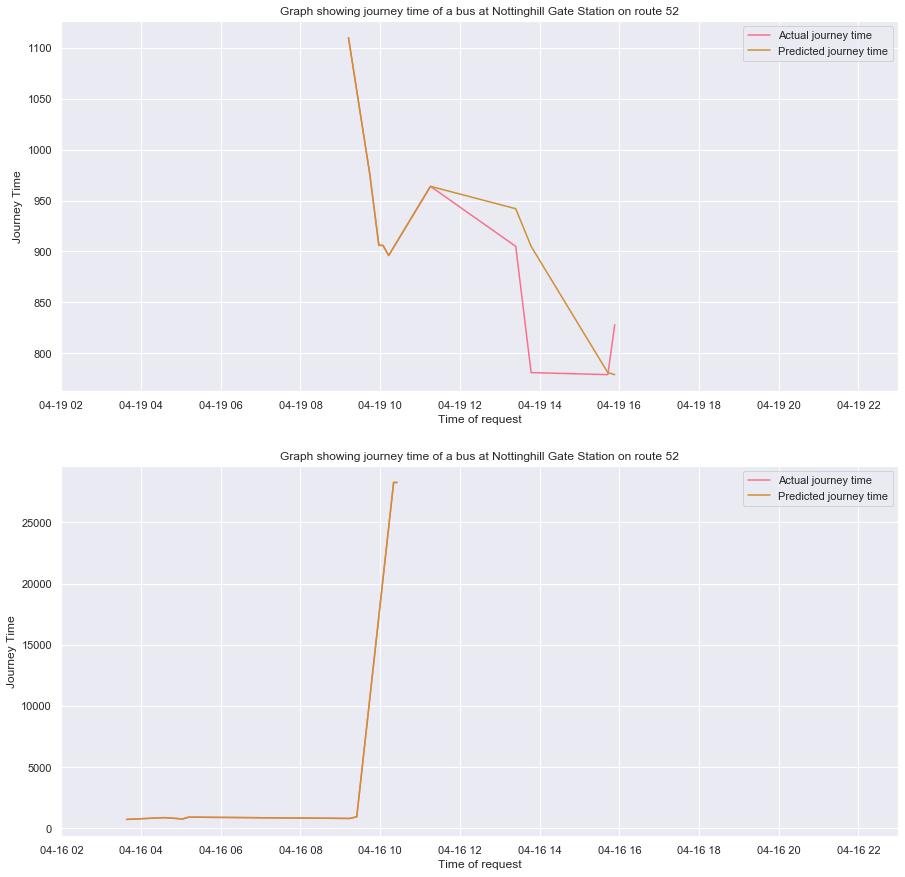

In [589]:
fig, ax = plt.subplots(figsize=(15,15), nrows=2, ncols=1)

ax[0].plot(times_52_190420, actual_jrny_52_190420, label="Actual journey time")
ax[0].plot(times_52_190420, preds_jrny_52_190420, label="Predicted journey time")
ax[0].set_xlabel("Time of request")
ax[0].set_ylabel("Journey Time")
ax[0].set_xlim([dt.datetime(2020, 4, 19, 2), dt.datetime(2020, 4, 19, 22, 59, 59)])
ax[0].set_title("Graph showing journey time of a bus at Nottinghill Gate Station on route 52")
ax[0].legend()

ax[1].plot(times_52_160420, actual_jrny_52_160420, label="Actual journey time")
ax[1].plot(times_52_160420, preds_jrny_52_160420, label="Predicted journey time")
ax[1].set_xlabel("Time of request")
ax[1].set_ylabel("Journey Time")
ax[1].set_xlim([dt.datetime(2020, 4, 16, 2), dt.datetime(2020, 4, 16, 22, 59, 59)])
ax[1].set_title("Graph showing journey time of a bus at Nottinghill Gate Station on route 52")
ax[1].legend()
plt.show()

### Measuring Success

**Explained variance regression score function**: Best possible score is 1.0, lower values are worse. https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score 

In [447]:
from sklearn.metrics import mean_squared_error, explained_variance_score

actual_seconds_52 = [a.timestamp() for a in accs_52_160420]
pred_seconds_52 = [p.timestamp() for p in preds_52_160420]
evs = explained_variance_score(actual_seconds_52, pred_seconds_52)
print("Explain variance score: ", evs)

Explain variance score:  0.999970640949991


### Different gaps for predictions for bus route 14

Experiment with different gaps to report back

Look for the leave stop}: For route X, find what stop is 15 stops before stop B. Denote this stop as stop A, which will be used to calculate the journey time of the buses. A gap of smaller and larger than 15 stops was tried, however, it was found that when using stops that were too close to each other e.g. a gap of under 5, SOMETHING WAS FOUND. It was also found that when using stops that were too far away from each other e.g. a gap of more than 25 stops, SOMETHING ELSE WAS FOUND. 

In [ ]:
print("Number of stops in route 14: ", len(stops_in_sequence_outbound.get("14")))
stop_a = stops_in_sequence_outbound.get("14")[1]

# Gap = 5
stop_b_5 = stops_in_sequence_outbound.get("14")[6]

# Gap = 10
stop_b_10 = stops_in_sequence_outbound.get("14")[11]

# Gap = 15
stop_b_15 = stops_in_sequence_outbound.get("14")[16]

# Gap = 20
stop_b_20 = stops_in_sequence_outbound.get("14")[21]

# Gap = 25
stop_b_25 = stops_in_sequence_outbound.get("14")[26]

# Gap = 30
stop_b_30 = stops_in_sequence_outbound.get("14")[31]

# Gap = 35
stop_b_35 = stops_in_sequence_outbound.get("14")[36]

destination_stops = [stop_b_5, stop_b_10, stop_b_20, stop_b_25, stop_b_30, stop_b_35]
print("origin stop: ", stop_a)
print("destiation stops: ", destination_stops)

In [ ]:
b_14 = data["14"]

stop_a_entries = b_14.loc[(b_14['bus_stop_name'] == stop_a) & (b_14['direction'] == 'outbound')]
[_, stop_a_id, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
print(stop_a_entries.shape)
print(stop_a_id)

In [ ]:
full_preds_varying_gaps = []
full_actual_varying_gaps = []
full_req_varying_gaps = []

req_times_14_060520 = generate_random_request_times("2020-05-06 03:00:00", "2020-05-06 20:00:00", 12)

for i, end in enumerate(destination_stops):
    stop_b_entries = b_14.loc[(b_14['bus_stop_name'] == destination_stops[i]) & (b_14['direction'] == 'outbound')]
    [_, stop_b_id, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')

    preds_14_060520 = []
    accs_14_060520 = []
    req_timesx_14_060520 = []

    for req_time in req_times_6_060520:
        p, a = pred_eval_arrival_times_mult(req_time, stop_a_entries, stop_b_entries, stop_a_id, stop_b_id)
        if a == 0:
            continue
        req_timesx_14_060520.append(req_time)
        preds_14_060520.append(p)
        accs_14_060520.append(a)
        
    full_preds_varying_gaps.append(preds_14_060520)
    full_actual_varying_gaps.append(accs_14_060520)
    full_req_varying_gaps.append(req_timesx_14_060520)

In [ ]:
for i, gap in enumerate(destination_stops):
    p = full_preds_varying_gaps[i]
    a = full_actual_varying_gaps[i]
    t = full_req_varying_gaps[i]
    r = [convert_time_to_datetime(x) for x in t]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(r, a, label="Actual arrival time")
    ax.plot(r, p, label="Predicted arrival time")
    ax.set_xlabel("Time of request")
    ax.set_ylabel("Arrival Time")
    ax.set_ylim([dt.datetime(2020, 5, 6, 2), dt.datetime(2020, 5, 6, 22, 59, 59)])
    ax.set_xlim([dt.datetime(2020, 5, 6, 2), dt.datetime(2020, 5, 6, 22, 59, 59)])
    ax.set_title("Gap = {}, End Stop = {}".format((i + 1) * 5, destination_stops[i]))
    ax.legend()
    plt.show()

In [451]:
for i, gap in enumerate(destination_stops):
    p = full_preds_varying_gaps[i]
    a = full_actual_varying_gaps[i]
    t = full_req_varying_gaps[i]
    actual_seconds_14 = [x.timestamp() for x in a]
    pred_seconds_14 = [x.timestamp() for x in p]
    evs = explained_variance_score(actual_seconds_14, pred_seconds_14)
    print("Gap = {} Explain variance score = {}".format((i + 1) * 5, evs))

Gap = 5 Explain variance score = 0.999914196340387
Gap = 10 Explain variance score = 0.999607017570896
Gap = 15 Explain variance score = 0.9988003937122831
Gap = 20 Explain variance score = 0.9194859215288302
Gap = 25 Explain variance score = 0.849248737652785
Gap = 30 Explain variance score = 0.0


### Putting it all together

The user gives their desired bus stop and bus route and gets a predicted arrival time back.

In [508]:
def get_pred_and_actual_arrival_time(route, stop):
    # Will need to do something about inbound or outbound
    
    df = data[route]

    stop_b_entries = df.loc[(df['bus_stop_name'] == stop) & (df['direction'] == 'inbound')]
    [_, stop_b_id, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')
    
    b_stop_index = stops_in_sequence_inbound.get(route).index(stop)
    a_stop_index = b_stop_index - 5 if (b_stop_index - 5) >= 0 else 0 
    a_stop_name = stops_in_sequence_inbound.get(route)[a_stop_index]
    print("{} to {}".format(a_stop_name, stop))
    
    stop_a_entries = df.loc[(df['bus_stop_name'] == a_stop_name) & (df['direction'] == 'inbound')]
    [_, stop_a_id, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
    
    # req_time = dt.datetime.now()
    req_time = "2020-05-12 07:30:00"
    
    print("Request time is ", req_time)
    
    pred_arr = 0
    
    while pred_arr == 0:
        pred_jrny_time, most_recent_left = predict_journey_time(req_time, stop_a_entries, stop_b_entries, stop_a_id)
        print("Predicted journey time is ", (pred_jrny_time)/60)
        
        if pred_jrny_time == 0:
            print("Unable to find any journeys")
            pred_arr = 0
        else:
            pred_arr, bus_to_track = pred_arrival_time(req_time, stop_a_entries, pred_jrny_time, most_recent_left)

        
        if pred_arr == 0:
            print("Couldn't find correlating leaving bus, go back 1 more stop")
            a_stop_index = a_stop_index - 1

            if a_stop_index < 0:
                print("No journeys found on entire route")
                return 0, 0

            a_stop_name = stops_in_sequence_inbound.get(route)[a_stop_index]
            stop_a_entries = df.loc[(df['bus_stop_name'] == a_stop_name) & (df['direction'] == 'inbound')]
            [_, stop_a_id, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
            print("{} to {}".format(a_stop_name, stop))

    print("Predicted arrival time is {}".format(pred_arr))
    actual_arr = get_actual(stop_b_entries, req_time)
    
    if actual_arr is None:
        print("There is no bus arriving at req_time")
        return pred_arr, 0
    
    return pred_arr, actual_arr

In [500]:
user_route = "267"
user_stop = "Ravenscourt Park"

predicted_arr_time, actual_arr_time = get_pred_and_actual_arrival_time(user_route, user_stop)

Clifton Gardens to Ravenscourt Park
Request time is  2020-05-12 07:30:00
most recent left bus left at  2020-05-12 07:20:06
Predicted journey time is  4.005357142857143
leave time =  2020-05-12 07:38:18
There are no more buses due
Couldn't find correlating leaving bus, go back 1 more stop
Turnham Green Church to Ravenscourt Park
most recent left bus left at  2020-05-12 07:19:02
Predicted journey time is  5.251785714285715
leave time =  2020-05-12 07:37:48
There are no more buses due
Couldn't find correlating leaving bus, go back 1 more stop
Chiswick Road to Ravenscourt Park
most recent left bus left at  2020-05-12 07:17:46
Predicted journey time is  6.445436507936509
leave time =  2020-05-12 07:37:05
There are no more buses due
Couldn't find correlating leaving bus, go back 1 more stop
Gunnersbury Station to Ravenscourt Park
Predicted journey time is  0.0
Unable to find any journeys
Couldn't find correlating leaving bus, go back 1 more stop
Thorney Hedge Road to Ravenscourt Park
most re